In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
from natsort import natsorted
import matplotlib.cm as cm
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import mnist
cmap = cm.hot

def get_img_files(folder):
    files = list(filter(lambda file: any(ext in file.lower() for ext in ['png','jpg','bmp']), os.listdir(folder)))
    files = natsorted(files)[::1]
    images = list(map(lambda x: cv2.imread(folder+'/'+x, 0), files))
    return np.array(images)

def img_to_coord(img):
    coord_mat = np.zeros((3, img.shape[0]*img.shape[1]))
    count = 0
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            coord_mat[0, count] = x
            coord_mat[1, count] = img.shape[0]-y
            coord_mat[2, count] = img[y, x]
            count += 1
    return coord_mat

def img_to_coord_tensor(img):
    height, width = img.shape
    img_transpose = torch.transpose(img, 0, 1).contiguous().view(1, width * height)

    x_coord = torch.arange(0, width).view(width, 1)
    x_coord = x_coord.expand(width, height).contiguous()
    x_coord = x_coord.view(1, width * height)

    y_coord = torch.arange(height, 0, -1)
    y_coord = y_coord.expand(width, height).contiguous()
    y_coord = y_coord.view(1, width * height)

    new_coord_matrix = np.vstack([x_coord.numpy(), y_coord.numpy()])
    img_tensor = np.vstack([new_coord_matrix, img_transpose.data.numpy()])

    return img_tensor

def plot_coord_mat(coord_mat, ax):
    ax.scatter(coord_mat[0, :], coord_mat[1, :], c=coord_mat[2, :])

def rotation_matrix(degrees):
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s, 0), (s, c, 0), (0, 0, 1)))
    return R

def weighted_pca_regression(x_vec, y_vec, weights):
    """
    Given three real-valued vectors of same length, corresponding to the coordinates
    and weight of a 2-dimensional dataset, this function outputs the angle in radians
    of the line that aligns with the (weighted) average and main linear component of
    the data. For that, first a weighted mean and covariance matrix are computed.
    Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
    """
    input_mat = np.stack([x_vec, y_vec])
    weights_sum = weights.sum()
    # Subtract (weighted) mean and compute (weighted) covariance matrix:
    mean_x, mean_y =  weights.dot(x_vec)/weights_sum, weights.dot(y_vec)/weights_sum
    centered_x, centered_y = x_vec-mean_x, y_vec-mean_y
    matrix_centered = np.stack([centered_x, centered_y])
    weighted_cov = matrix_centered.dot(np.diag(weights).dot(matrix_centered.T)) / weights_sum
    # We know that v rotates the data's main component onto the y=0 axis, and
    # that u rotates it back. Solving u.dot([x,0])=[x*u[0,0], x*u[1,0]] gives
    # f(x)=(u[1,0]/u[0,0])x as the reconstructed function.
    u,e,v = np.linalg.svd(weighted_cov)
    eig_val = np.sqrt(e)
    if u[1,0] < 0:
        eig_val[0] = -1*eig_val[0]
    if u[0,1] < 0:
        eig_val[1] = -1*eig_val[1]
        
    return eig_val[0]*u[:,0], eig_val[1]*u[:,1], np.array([mean_x, mean_y])
        
def coord_to_img(coord_mat, bbox=[-60,60,-60,60]):
    x_min = bbox[0]
    x_max = bbox[1]
    y_min = bbox[2]
    y_max = bbox[3]
    width = x_max - x_min
    height = y_max - y_min
    
    img = np.zeros([y_max-y_min, x_max-x_min])
    for col in range(coord_mat.shape[1]):
        x = coord_mat[0, col]
        y = coord_mat[1, col]
        val = coord_mat[2, col]
        new_x = int(x - x_min)
        new_y = int(y_max - y)
        if (0 <= new_x) and (new_x < width) and (0 <= new_y) and (new_y < height):
            img[new_y, new_x] = val
    return img

def object_extraction(coord_mat, min_val=0.2):
    min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
    extracted_object_coords = np.greater(coord_mat, min_pixel_val)
    new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
    coord_mat[2,extracted_object_coords[2,:]] = 0
    return new_object

def orientation_normalization(coord_mat):
        weights = coord_mat[2, :]
        primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        R = rotation_matrix(90-angle)
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 9/eig_2
        norm_scale_mat[1,1] = 18/eig_1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        return transformed_mat, R, mean_mat
    
def object_extraction(coord_mat, min_val=0.2):
    min_pixel_val = np.repeat([[min_val]], coord_mat.shape[1], axis=1) 
    extracted_object_coords = np.greater(coord_mat, min_pixel_val)
    new_object = coord_mat.copy()[:,extracted_object_coords[2,:]]
    coord_mat[2,extracted_object_coords[2,:]] = 0
    return new_object

def orientation_normalization(coord_mat):
        weights = coord_mat[2, :]
        primary_vector, seconday_vector, mean_vector = weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
        angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
        R = rotation_matrix(90-angle)
        mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
        mean_mat = np.diag(mean_mat)
        mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
        eig_1 = np.linalg.norm(primary_vector)
        eig_2 = np.linalg.norm(seconday_vector)
        norm_scale_mat = np.zeros([3,3])
        norm_scale_mat[0,0] = 9/eig_2
        norm_scale_mat[1,1] = 18/eig_1
        norm_scale_mat[2,2] = 1
        transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
        return transformed_mat, R, mean_mat

def erase_object(img, new_object):
    for col_num in range(new_object.shape[1]):
        col = new_object[:,col_num]
        img[img.shape[0]-col[1], col[0]] = 0

def insert_object(img, new_object_coords, location):
    for col_num in range(new_object_coords.shape[1]):
        col = new_object_coords[:, col_num]
        x = np.clip(location[0] + col[0], 0, img.shape[1] - 1)
        y = np.clip(-1*(location[1] + col[1] - 1)+img.shape[0], 0, img.shape[0] - 1)
        spill_over_x = x % 1
        spill_over_y = y % 1
        ceil_x = int(np.ceil(x))
        lower_x_weight = 1 - spill_over_x
        heigher_x_weight = spill_over_x
        
        ceil_y = int(np.ceil(y))
        lower_y_weight = 1 - spill_over_y
        heigher_y_weight = spill_over_y   
        
        pixel_value = col[2]
        max_pixel_val = 0.5
        img[ceil_y, ceil_x] = img[ceil_y, ceil_x] + pixel_value*heigher_y_weight*heigher_x_weight
        img[ceil_y, ceil_x - 1] = img[ceil_y, ceil_x - 1] + pixel_value*lower_x_weight*heigher_y_weight
        img[ceil_y - 1, ceil_x] = img[ceil_y - 1, ceil_x] + pixel_value*lower_y_weight*heigher_x_weight
        img[ceil_y - 1, ceil_x - 1] = img[ceil_y - 1, ceil_x - 1] + pixel_value*lower_y_weight*lower_x_weight
        img[ceil_y, ceil_x] = min(float(img[ceil_y, ceil_x]), max_pixel_val)
        img[ceil_y, ceil_x - 1] = min(float(img[ceil_y, ceil_x - 1]), max_pixel_val)
        img[ceil_y - 1, ceil_x] = min(float(img[ceil_y - 1, ceil_x]), max_pixel_val)
        img[ceil_y - 1, ceil_x - 1] = min(float(img[ceil_y - 1, ceil_x - 1]), max_pixel_val)
#         img[ceil_y, ceil_x] = pixel_value
    return img

def scale_and_rotate(img):
    new_new_coord_mat = img_to_coord_tensor(img)
    test = img_to_coord(img)
    new_object = object_extraction(new_new_coord_mat, min_val=0)
    erase_object(img, new_object)
    new_object2, _, _ = orientation_normalization(new_object)
    img = insert_object(img, new_object2, [50, 50])
    return img
    


for folder in ['fives','sixes','sevens','eights','nines','people'][:]:
    imgs = get_img_files(os.getcwd()+'/'+folder)

    coord_mats = []
    transformed_mats = []
    transformed_mats_2 = []
#     fig, ax = plt.subplots(3, figsize=(10,10))
    for index, img in enumerate(imgs[:]):
        img = cv2.resize(img, (100,100))
        img = img/img.max()
        img2 = Variable(torch.from_numpy(img))
        coord_mat = img_to_coord(img)
        coord_mat_2 = img_to_coord_tensor(img2)
#          plot_coord_mat(, ax[1])
#         ax[0].set_xlim([0,100])
#         ax[0].set_ylim([0,100])
#         ax[1].set_xlim([-60,60])
#         ax[1].set_ylim([-60,60])
#         ax[1].set_title("{}, {}".format(eig_1, eig_2))
#         tansform_mat, R, mean_mat = orientation_normalization(coord_mat.copy())
        coord_mats.append(coord_to_img(coord_mat.copy(), bbox=[0,100,0,100]))
#         transformed_mats_2.append(coord_to_img(np.matmul(R, coord_mat - mean_mat).copy(), bbox=[-60,60,-60,60]))
        
        img2 = scale_and_rotate(img2)
        print(folder, index)
        transformed_mats.append(img2.data.numpy())
        del img2

    fig2, ax2 = plt.subplots(1,2,figsize=(15,15))
    combined_orig = []
    combined_transformed = []
    # plot_coord_mat(coord_mats[0] + coord_mats[1], ax2[0])
    combined_orig = sum(coord_mats)
    combined_transformed = sum(transformed_mats)
#     combined_transformed_2 = sum(transformed_mats_2)
    ax2[0].imshow(combined_orig)
    ax2[0].set_title("Overlay of Original")
#     ax2[1].imshow(combined_transformed_2)
#     ax2[1].set_title("Overlay of Rotated")
    ax2[1].imshow(combined_transformed)
    ax2[1].set_title("Overlay of Rotated & scaled")
#     fig2.savefig("Sevens_full.png")
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), None and long or byte Variables are valid indices (got numpy.float64)

In [2]:
import scipy.io as sio
mat_contents = sio.loadmat('/mnt/c/Users/Rees/Downloads/training_and_validation_batches/training_and_validation_batches/1.mat')
nums = mat_contents['affNISTdata']
import matplotlib.pyplot as plt
print(nums[0][0][5].shape)
labels = nums[0][0][5].T
imgs = np.transpose(nums[0][0][2].reshape((40,40, 60000)), (2,0,1))
labels

(1, 60000)


array([[0],
       [1],
       [7],
       ...,
       [3],
       [7],
       [1]])

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


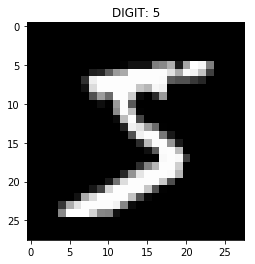

In [29]:
import os
from torchvision import datasets
import torch as th
# Change this to where you want to save the data
SAVE_DIR = os.path.expanduser(os.getcwd()+'/data/MNIST/')
# train data
mnist_train = datasets.MNIST(SAVE_DIR, train=True, download=False)
x_train_mnist, y_train_mnist = mnist_train.train_data.type(th.FloatTensor), mnist_train.train_labels
# test data
mnist_test = datasets.MNIST(SAVE_DIR, train=False, download=True)
x_test_mnist, y_test_mnist = mnist_test.test_data.type(th.FloatTensor), mnist_test.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.show()

In [31]:
from torchsample.transforms import RandomRotate
from torchsample.transforms  import AddChannel

from  torchsample.transforms import RandomCrop
# note that we DONT add the channel dim to transform - the same crop will be applied to each channel
rand_crop = RandomCrop((20,20))

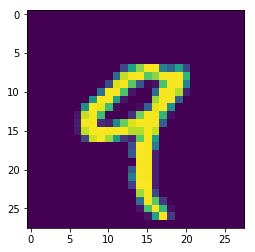

In [149]:
index = 4
x_example = add_channel(x_train_mnist[index])
plt.imshow(x_example[0].numpy())
plt.show()

tensor([0., 0.])
tensor([[[ 0.0140,  0.9999,  0.0000],
         [ 0.9999, -0.0140,  0.0000]]])


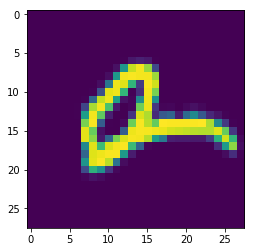

In [152]:
import torch.nn.functional as F
rotation = torch.Tensor([[1/1.0,0],[0, 1/1.0]])
rotation = rot
translation = torch.Tensor([0, 0])
theta = torch.Tensor([[0, 0, 0],[0, 0, 0]])
theta[:2, :2] = rotation
print(theta[:, 2])
theta[:, 2] = translation
theta = theta.view(1, 2, 3)
print(theta)
x_batch = x_example.view(1, 1, 28, 28)
x_flat = x_example.view(1, 28 * 28)
grid = F.affine_grid(theta, x_batch.size())
x = F.grid_sample(x_batch, grid)
plt.imshow(x[0][0])

u, s, v = torch.svd(x[0][0])

torch.Size([3, 784])
U: tensor([[ 0.0140,  0.9999],
        [ 0.9999, -0.0140]])
tensor([[ 0.0140,  0.9999],
        [ 0.9999, -0.0140]]) tensor(13.7118) tensor(13.9205)


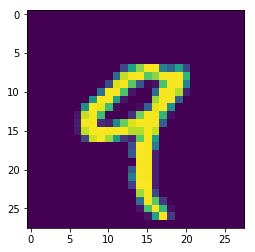

In [151]:
def img_to_coord_tensor(img, img_num, tensor_index):
    """
    Takes in a 4D image and returns the 3*W*H coordinate representation
    """
    _, _, height, width = img.shape
    flattened_img = torch.transpose(img[img_num, tensor_index], 0, 1).contiguous().view(width * height)
    x_coord = torch.arange(0, width).view(width, 1)
    x_coord = x_coord.expand(width, height).contiguous()
    x_coord = x_coord.view(width * height).float()

    y_coord = torch.arange(height, 0, -1)
    y_coord = y_coord.expand(width, height).contiguous()
    y_coord = y_coord.view(width * height).float()

    new_coord_matrix = np.vstack([x_coord.numpy(), y_coord.numpy()])
    img_tensor = torch.stack((x_coord, y_coord, flattened_img))

    return img_tensor

def weighted_pca(coord_mat):
    """
    Given three real-valued vectors of same length, corresponding to the coordinates
    and weight of a 2-dimensional dataset, this function outputs the angle in radians
    of the line that aligns with the (weighted) average and main linear component of
    the data. For that, first a weighted mean and covariance matrix are computed.
    Then u,e,v=svd(cov) is performed, and u * f(x)=0 is solved.
    """
    x_vec = coord_mat[0, :]
    y_vec = coord_mat[1, :]
    weights = coord_mat[2, :]
    weight_mat = torch.diag(weights)
    weights_sum = weights.sum()
    # Subtract (weighted) mean and compute (weighted) covariance matrix:
    mean_x, mean_y = torch.dot(weights, x_vec)/weights_sum, torch.dot(weights, y_vec)/weights_sum
    coord_mat[0, :] -= mean_x
    coord_mat[1, :] -= mean_y
    centered_mat = coord_mat[[0, 1], :]
    weighted_cov = torch.mm(centered_mat, torch.mm(weight_mat, torch.t(centered_mat) )) / weights_sum
    u,e,v = torch.svd(weighted_cov)
    eig_val = torch.sqrt(e)
    if u[1,0] < 0:
        eig_val[0] = -1*eig_val[0]
    if u[0,1] < 0:
        eig_val[1] = -1*eig_val[1]
    print("U:", u)
    scale_mat = torch.Tensor([[]])
#     rotation_mat = torch.stack([eig_val[0]**(-1)*u[:,0], eig_val[1]**(-1)*u[:,1]])
#     rotation_mat = torch.t(rotation_mat)
    return u, mean_x, mean_y

    
# def frame_decomposition(img_batch, img_num, tensor_index):
#     coord_mat = img_to_coord_tensor(img_batch, img_num, tensor_index)
#     weights = coord_mat[2, :] 

# def orientation_normalization(self, coord_mat, eig_width, eig_height):
#     weights = coord_mat[2, :]
#     primary_vector, seconday_vector, mean_vector = self.weighted_pca_regression(coord_mat[0,:], coord_mat[1,:], coord_mat[2,:])
#     angle = np.arctan2(primary_vector[1], primary_vector[0]) * 180 / np.pi
#     R = rotation_matrix(90-angle)
#     mean_mat = np.array([mean_vector[0], mean_vector[1], 0])
#     mean_mat = np.diag(mean_mat)
#     mean_mat = np.matmul(mean_mat, np.ones(coord_mat.shape))
#     eig_1 = np.linalg.norm(primary_vector)
#     eig_2 = np.linalg.norm(seconday_vector)
#     norm_scale_mat = np.zeros([3,3])
#     norm_scale_mat[0,0] = 1
#     norm_scale_mat[1,1] = 1
#     norm_scale_mat[2,2] = 1
#     return norm
#     transformed_mat = np.matmul(norm_scale_mat, np.matmul(R, coord_mat - mean_mat))
#     return transformed_mat, (90-angle), mean_mat

x_batch_coord = img_to_coord_tensor(x_batch, 0, 0)
print(x_batch_coord.shape)
rot, mean_x, mean_y = weighted_pca(x_batch_coord)
print(rot, mean_x, mean_y)
plt.imshow(x[0][0])

In [64]:
a = torch.Tensor([[1,1], [2,2]])
print(a)
b = a
b[1, :] -= 5
print(b[[0,1], :])
# torch.mm(a, b, b)

tensor([[1., 1.],
        [2., 2.]])
tensor([[ 1.,  1.],
        [-3., -3.]])


In [78]:
a = torch.Tensor([1,2,3,4]).long()
b = torch.Tensor([5,6,7,8]).long()
torch.stack((a,b, b)).shape

torch.Size([3, 4])